In [2]:
using GpABC,OrdinaryDiffEq, Distances, Distributions, Plots, StatsBase, Printf, ODE, DifferentialEquations, Statistics, ModelingToolkit, CSV
using DelimitedFiles, StatsPlots, Dates
import Base.Iterators
include("setup_ABC.jl")
gr()

function log_euclidean(x,y)
    output = sqrt(sum((log10.(x.+0.00001) - log10.(y.+0.00001)) .^ 2))
    return (output/size(x)[1]) #average by the length of the vector
end

log_euclidean (generic function with 1 method)

In [3]:
@parameters t

@variables s_out(t) rmr(t) em(t) rmq(t) rmt(t) et(t) rmm(t) mt(t) mm(t) q(t) si(t) mq(t) mr(t) r(t) NH4(t) nit_mrna(t) nit_mrna_ribo(t) nit(t) NH4_ex(t) N(t) a(t) AA(t) AA_prot(t) AA_mrna(t) AA_mrna_ribo(t)

#############check the last parameter k_ribo_a
###############

@parameters k_cat_AA k_a_NH4 k_NH4 k_a_AA k_NH4_AA k_a #these are the parameters to be varied in ABC
gam= (gmax*a*AA)/(k_ribo_a*k_ribo_a_AA+k_ribo_a_AA*a+k_ribo_AA_a*AA+a*AA) #updated gamma equation that uses both ATP and AA
ttrate= (rmq + rmr + rmt + rmm + nit_mrna_ribo+AA_mrna_ribo)*gam #total translation rate (sum of the mRNA/ribosome complexes times translation rate)
lam= ttrate/M #lambda is the growth rate
nucat= em*vm*si/(Km + abs(si))
AA_vo = ((k_cat_AA*2*a*NH4)/(k_a_NH4*k_a))/(1+(1+(AA/k_a_AA))+(NH4/k_a_NH4)+(1+(AA/k_NH4_AA))+(NH4/k_NH4))
new_AA = AA_vo*AA_prot
AA_a_use = new_AA*2 #each AA produced uses x number of ATP molecules
AA_NH4_use = new_AA*2 #each AA produced uses 2 NH4 molecules
export_rate = 0 #export rate of NH4
fixation = 0
death_rate = 0
k_ribo_a_AA = 10000.0
k_ribo_AA_a = 10000.0
k_ribo_a = 10.0

@derivatives D'~t

eqs = [
    D(s_out)~ 0 #((-et*vt*s_out/(Kt+s_out))*N)-ds*s_out+(export_rate*NH4*50)+1e7
    D(rmr)~ kb*r*mr-ku*rmr-(gam/nr)*rmr-lam*rmr
    D(em)~ (gam/nx)*rmm-lam*em
    D(rmq)~ kb*r*mq-ku*rmq-(gam/nx)*rmq-lam*rmq
    D(rmt)~ kb*r*mt-ku*rmt-gam/nx*rmt-lam*rmt
    D(et)~ (gam/nx)*rmt-lam*et
    D(rmm)~ kb*r*mm-ku*rmm-gam/nx*rmm-lam*rmm
    D(mt)~ (we*a/(thetax+a))+ku*rmt+(gam/nx)*rmt-kb*r*mt-dm*mt-lam*mt
    D(mm)~ (we*a/(thetax+a))+ku*rmm+(gam/nx)*rmm-kb*r*mm-dm*mm-lam*mm
    D(q)~ (gam/nx)*rmq-lam*q
    D(si)~ (et*vt*s_out/(Kt+s_out))-nucat-lam*si
    D(mq)~ (wq*a/(thetax+a)/(1+(q/Kq)^nq))+ku*rmq+(gam/nx)*rmq-kb*r*mq-dm*mq-lam*mq
    D(mr)~ (wr*a/(thetar+a))+ku*rmr+(gam/nr)*rmr-kb*r*mr-dm*mr-lam*mr
    D(r)~ ku*rmr+ku*rmt+ku*rmm+ku*rmq+(gam/nr)*rmr+(gam/nr)*rmr+(gam/nx)*rmt+(gam/nx)*rmm+(gam/nx)*rmq-kb*r*mr-kb*r*mt-kb*r*mm-kb*r*mq+ku*nit_mrna_ribo+(gam/nx)*nit_mrna_ribo-kb*r*nit_mrna+ku*AA_mrna_ribo+(gam/nx)*AA_mrna_ribo-kb*r*AA_mrna-lam*r
    D(NH4)~ 0 #fixation*nit-export_rate*NH4-lam*NH4-AA_NH4_use+2.3e6
    D(nit_mrna)~ 0 #(v_nit*a/(thetax + a))+(ku*nit_mrna_ribo)+(gam/nx*nit_mrna_ribo)-(kb*r*nit_mrna)-(dm*nit_mrna)-(lam*nit_mrna) #num of free nitrogenase coding mRNA
    D(nit_mrna_ribo)~ 0 #(kb*r*nit_mrna)-(ku*nit_mrna_ribo)-(gam/nx*nit_mrna_ribo)-(lam*nit_mrna_ribo) #num of nit mRNA-ribosome complexes
    D(nit)~ 0 #(gam/nx)*nit_mrna_ribo-lam*nit #num of nitrogenase proteins
    D(NH4_ex)~ 0 #(export_rate*NH4)#total num of NH4 molecules exported this timestep
    D(N)~ 0 #lam*N-death_rate*N #the change in num of bacterial cells instead of just loss to dilution
    D(a)~ ns*nucat-ttrate-fixation*nit-AA_a_use-lam*a
    D(AA)~ new_AA-ttrate-lam*AA
    D(AA_prot)~ (gam/nx)*AA_mrna_ribo-lam*AA_prot
    D(AA_mrna)~ ((w_AA*a/(thetax+a)))+(ku*AA_mrna_ribo)+(gam/nx*AA_mrna_ribo)-(kb*r*AA_mrna)-(dm*AA_mrna)-(lam*AA_mrna)
    D(AA_mrna_ribo)~ (kb*r*AA_mrna)-(ku*AA_mrna_ribo)-(gam/nx*AA_mrna_ribo)-(lam*AA_mrna_ribo)
];

println("System defined successfully")

System defined successfully


burning in model
success
plotting


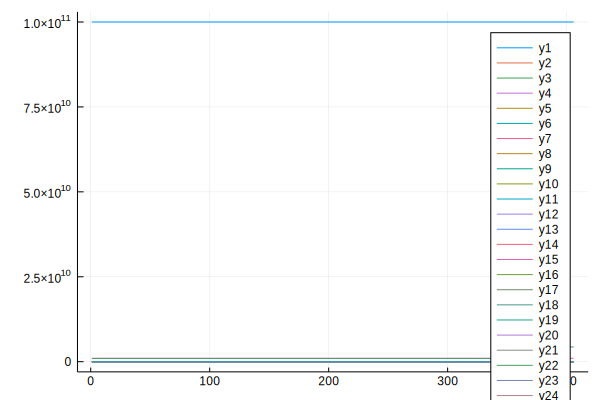

In [4]:
de = ODESystem(eqs, t, [s_out, rmr, em, rmq, rmt, 
        et, rmm, mt, mm, q, si, mq, mr, r, NH4, nit_mrna,
        nit_mrna_ribo, nit, NH4_ex, N, a, AA, AA_prot,
        AA_mrna, AA_mrna_ribo],[k_cat_AA,k_a_NH4 ,k_NH4, k_a_AA, k_NH4_AA, k_a])

f = ODEFunction(de)
p = [10.0,10.0,10.0,10.0,10.0,10.0]
burn_in_prob_abc = ODEProblem(f, init, (0.,10000.0),p) #set up the burn in problem

println("burning in model")
sol = solve(burn_in_prob_abc)
println("success")
step_num = size(sol,2)
final_state =sol[step_num]; #run the burn in stage and collect the end state to use as new initial values

prob_abc = ODEProblem(f, final_state, (0.,10000.0),p) #the problem to run ABC on using the burned in initial values
sol2 = solve(prob_abc)
println("plotting")
plot(sol')#ylim = (0,20000))
# plot!(log10.(sol2.+0.00001))


In [5]:
function simulator_function_lm(params, time1= 10000.0)
    global k_cat_AA = 10. #params[1]
    global k_a_NH4 =  params[1]
    global k_NH4 = params[2]
    global k_a_AA = 10. #params[4]
    global k_NH4_AA = 10. #params[5]
    global k_a = params[3]
    prob = ODEProblem(AA_simple, final_state,(0., time1),params)
    sol = solve(prob, saveat = 1.)
    return Array{Float64, 2}(sol)
end

simulator_function_lm (generic function with 2 methods)

In [11]:
population_colors=["#FF2F4E", "#D0001F", "#A20018", "#990017", "#800013"]

threshold_schedule = [0.005,0.001, 0.0007, 0.0005, 0.0001,0.00005];
priors = [Uniform(0., 20.0), Uniform(0.,20.0), Uniform(0., 20.0)]
#     ,Uniform(2., 30.), Uniform(2., 30.), Uniform(2., 30.)]
n_particles = 300

real_param_vect1 = []
real_param_vect2 = []
real_param_vect3= []
final_popns1 = []
final_popns2 = []
final_popns3 = []
difference_vect = []

0-element Array{Any,1}

In [26]:
for i in range(1,stop = 20)

#generate dummy data with 1 random param between 0 and 20
params_lm = rand(3)*20
results = simulator_function_lm(params_lm);

#run abc smc to try and recreate the 1 random param value
sim_abcsmc_res = SimulatedABCSMC(results,
    simulator_function_lm,
    priors,
    threshold_schedule,
    n_particles,
    distance_function = log_euclidean,
    max_iter=convert(Int, 2e6),
    write_progress=true)

mean1 = mean(sim_abcsmc_res.population[6][:,1])
mode1 = mode(sim_abcsmc_res.population[6][:,1])
println("estimated paramter mean is $mean1, mode is $mode1")
mean2 = mean(sim_abcsmc_res.population[6][:,2])
mode2 = mode(sim_abcsmc_res.population[6][:,2])
println("estimated paramter mean is $mean2, mode is $mode2")
mean3 = mean(sim_abcsmc_res.population[6][:,3])
mode3 = mode(sim_abcsmc_res.population[6][:,3])
println("estimated paramter mean is $mean3, mode is $mode3")
println("true parameters are $params_lm")
push!(real_param_vect1, params_lm[1])
push!(real_param_vect2, params_lm[2])
push!(real_param_vect3, params_lm[3])
println("difference for round $i is")
println(euclidean([mean1,mean2,mean3],params_lm))
push!(difference_vect,euclidean([mean1,mean2,mean3],params_lm))
    #save the final populations of the two parameters
push!(final_popns1, sim_abcsmc_res.population[6][:,1])
push!(final_popns2, sim_abcsmc_res.population[6][:,2])
push!(final_popns3, sim_abcsmc_res.population[6][:,3])
end

┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 286/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 7.104803225103691, mode is 5.436977895381194
estimated paramter mean is 13.862363119162922, mode is 10.22642985919159
estimated paramter mean is 14.919114192144047, mode is 15.735537328851786
true parameters are [8.763666527483904, 19.805414688987135, 19.66093825517989]
difference for round 1 is
7.781811155660332


┌ Info: GpABC SMC simulation accepted 295/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 10.194300756148715, mode is 11.269317382455112
estimated paramter mean is 14.943475900467925, mode is 15.613374331131434
estimated paramter mean is 6.229099895487184, mode is 4.2681912511359315
true parameters are [8.608199697146116, 13.180152528582752, 3.8788192901709273]
difference for round 2 is
3.338988590416477


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 218/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238


estimated paramter mean is 9.633558050455262, mode is 10.582271420412223
estimated paramter mean is 5.547815471526817, mode is 4.958389212675019
estimated paramter mean is 13.01416539600234, mode is 11.778169464050844
true parameters are [12.770088750482644, 6.692422002981679, 4.9212731855330505]
difference for round 3 is
8.754590411569117


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 133/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 279/2000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 6.608479233288581, mode is 4.729431918916297
estimated paramter mean is 16.260418987717923, mode is 14.635841039696443
estimated paramter mean is 9.852679771052772, mode is 13.496980382717418
true parameters are [6.659849634818511, 19.289416871516437, 9.8572624230612]
difference for round 4 is
3.029436927699379


┌ Info: GpABC SMC simulation accepted 220/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 10/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 29/2000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 34/

estimated paramter mean is 17.73141972744992, mode is 16.883543609129504
estimated paramter mean is 0.3658960790142474, mode is 0.4421527503850394
estimated paramter mean is 11.803954415056381, mode is 8.638673957693646
true parameters are [13.053011346472152, 0.2168002460013696, 18.65904216804381]
difference for round 5 is
8.300720610150849


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 10.688670853880375, mode is 12.62016515447814
estimated paramter mean is 11.95458527250302, mode is 10.701111701790932
estimated paramter mean is 15.879168501813766, mode is 14.316044870281733
true parameters are [9.891348197718823, 11.352445229267115, 18.257078115739894]
difference for round 6 is
2.5792925738851262


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 13.917607035276717, mode is 14.384209701576054
estimated paramter mean is 11.277502469931877, mode is 10.984408897417488
estimated paramter mean is 7.671391829411832, mode is 11.051719416237848
true parameters are [4.9412679424958394, 3.334533474830126, 5.660421998013834]
difference for round 7 is
12.153576413078039


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 201/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 178/1000 particles.
└ @ GpABC C:\User

estimated paramter mean is 17.12008003068545, mode is 17.90424812118062
estimated paramter mean is 3.5567872601280532, mode is 2.9778289719797684
estimated paramter mean is 14.078461841195653, mode is 16.022690812375934
true parameters are [13.353990833399777, 2.4128515183607435, 17.979312287661607]
difference for round 8 is
5.541538687846383


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 14.415043275781105, mode is 17.61567186069157
estimated paramter mean is 4.559799275555029, mode is 5.358841110286834
estimated paramter mean is 11.93081190593785, mode is 5.261019197617451
true parameters are [10.469325682663415, 2.6523342575624875, 2.0159031441912845]
difference for round 9 is
10.840319454391672


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 182/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 231/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238


estimated paramter mean is 12.10360462655062, mode is 10.954512181508694
estimated paramter mean is 14.326775309675796, mode is 18.661528707061507
estimated paramter mean is 6.519446586302111, mode is 12.374025870349161
true parameters are [11.008043349496353, 17.88149631751125, 11.413622932564053]
difference for round 10 is
6.147296809463276


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 9.409734115073807, mode is 8.439953382293684
estimated paramter mean is 14.95061099094359, mode is 13.66015328133042
estimated paramter mean is 13.681396076676165, mode is 13.907383124167803
true parameters are [10.858140544973423, 19.231570163760622, 17.742894849392748]
difference for round 11 is
6.076204811087193


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 273/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238


estimated paramter mean is 11.11901508945078, mode is 12.580287749754731
estimated paramter mean is 11.160832400012804, mode is 10.905367699384254
estimated paramter mean is 7.261872761629781, mode is 7.509167790980536
true parameters are [15.020572154652871, 15.60296810716116, 4.194175209016042]
difference for round 12 is
6.660742109409664


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 180/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238


estimated paramter mean is 5.856295007386859, mode is 3.0643732572119236
estimated paramter mean is 6.475274062899595, mode is 3.1090767112557667
estimated paramter mean is 7.677572520760265, mode is 12.917332964795149
true parameters are [9.230539725313864, 12.619720076060315, 19.91613457093578]
difference for round 13 is
14.103976222367269


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 14.960721173270409, mode is 18.899612112969493
estimated paramter mean is 15.38898586120733, mode is 14.910499505960958
estimated paramter mean is 9.968468731182917, mode is 2.3740682182143793
true parameters are [6.429341020148853, 7.198651710586255, 17.013113533669305]
difference for round 14 is
13.76564714094854


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 233/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238


estimated paramter mean is 15.544830698255904, mode is 17.973172533575422
estimated paramter mean is 6.922649637908801, mode is 7.987710879743442
estimated paramter mean is 11.092312673247609, mode is 8.325192741335679
true parameters are [6.833829374208311, 2.6013213992697803, 17.09939573267694]
difference for round 15 is
11.429806153058799


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 265/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238


estimated paramter mean is 8.676151709718143, mode is 2.2779025065618397
estimated paramter mean is 9.694860262906921, mode is 1.6066542639881893
estimated paramter mean is 11.324139073222996, mode is 17.78725119029529
true parameters are [9.214323158552698, 10.726137278581046, 9.247626889406417]
difference for round 16 is
2.380139416281557


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 15.438701051911215, mode is 19.495400381699742
estimated paramter mean is 11.910176682924028, mode is 10.99329812492182
estimated paramter mean is 10.223536920776775, mode is 6.360815904740111
true parameters are [16.230075253772156, 12.69876569738145, 10.345187048149933]
difference for round 17 is
1.123808041697458


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 17/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 39/2000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 62/3000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 77/4

estimated paramter mean is 11.721694274097768, mode is 14.170404371463906
estimated paramter mean is 1.7746584499806852, mode is 2.1394509155871115
estimated paramter mean is 6.7881532307840295, mode is 3.7135772874130404
true parameters are [16.49850288240781, 2.631732600968215, 9.362431138633678]
difference for round 18 is
5.493576551533497


┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation accepted 140/1000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238
┌ Info: GpABC SMC simulation accepted 270/2000 particles.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:238


estimated paramter mean is 13.444041255152198, mode is 15.038330233604388
estimated paramter mean is 5.463644425977988, mode is 4.42010170137673
estimated paramter mean is 15.431583470077506, mode is 17.17688981812446
true parameters are [11.58712115778982, 4.4672925803737495, 18.966020465220026]
difference for round 19 is
4.114986527421368


┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC rejection simulation. ϵ = 0.005.
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\rejection.jl:47
┌ Info: GpABC SMC simulation ϵ = 0.001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0007
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0005
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 0.0001
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193
┌ Info: GpABC SMC simulation ϵ = 5.0e-5
└ @ GpABC C:\Users\leann\.julia\packages\GpABC\1GAUU\src\abc\smc.jl:193


estimated paramter mean is 10.181724365013993, mode is 11.455120867511827
estimated paramter mean is 9.119535534685248, mode is 9.371363521007858
estimated paramter mean is 14.887611640527807, mode is 10.31988567048146
true parameters are [4.400258593087245, 3.2626490637335026, 7.334302235810668]
difference for round 20 is
11.17053931414981


In [27]:
# writedlm("results/20_04_15_ABC_SMC_final_popn1.txt", final_popns1, ",")
# writedlm("results/20_04_15_ABC_SMC_final_popn2.txt", final_popns2, ",")
# writedlm("results/20_04_15_ABC_SMC_final_popn3.txt", final_popns3, ",")
# writedlm("results/20_04_15_ABC_SMC_difference_vect_3_params.txt", difference_vect, ",")
# writedlm("results/20_04_15_ABC_SMC_real_params1.txt", real_param_vect1, ",")
# writedlm("results/20_04_15_ABC_SMC_real_params2.txt", real_param_vect2, ",")
# writedlm("results/20_04_15_ABC_SMC_real_params3.txt", real_param_vect3, ",")

In [7]:
final_popns1= Array(CSV.read("results/20_04_15_ABC_SMC_final_popn1.txt" ))
final_popns2= Array(CSV.read("results/20_04_15_ABC_SMC_final_popn2.txt" ))
final_popns3= Array(CSV.read("results/20_04_15_ABC_SMC_final_popn3.txt" ))
difference_vect= Array(CSV.read("results/20_04_15_ABC_SMC_difference_vect_3_params.txt" ))
real_param_vect1= Array(CSV.read("results/20_04_15_ABC_SMC_real_params1.txt" ))
real_param_vect2=Array(CSV.read("results/20_04_15_ABC_SMC_real_params2.txt" ));
real_param_vect3=Array(CSV.read("results/20_04_15_ABC_SMC_real_params3.txt" ));

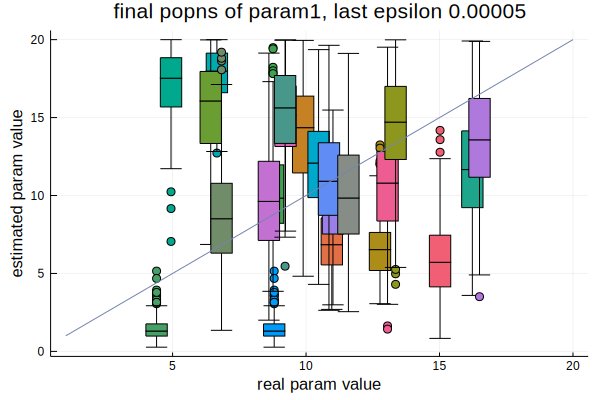

In [39]:
boxplot(real_param_vect1', final_popns1',title = "final popns of param1, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", label = "")
plot!(1:20, label = "")

In [42]:
real_param_vect1

22×1 Array{Float64,2}:
  8.80662193900935  
 10.965167713887759 
  8.763666527483904 
  8.608199697146116 
 12.770088750482644 
  6.659849634818511 
 13.053011346472152 
  9.891348197718823 
  4.9412679424958394
 13.353990833399777 
 10.469325682663415 
 11.008043349496353 
 10.858140544973423 
 15.020572154652871 
  9.230539725313864 
  6.429341020148853 
  6.833829374208311 
  9.214323158552698 
 16.230075253772156 
 16.49850288240781  
 11.58712115778982  
  4.400258593087245 

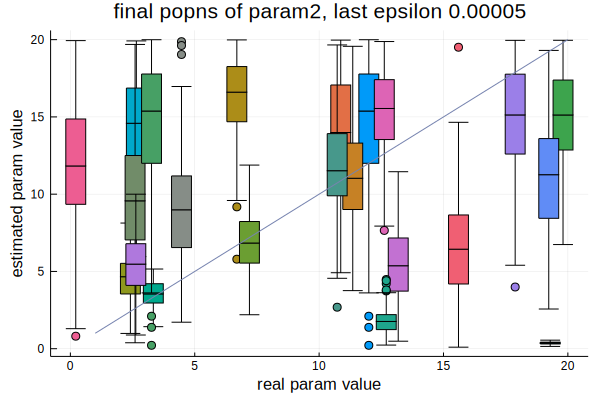

In [40]:
boxplot(real_param_vect2', final_popns2',title = "final popns of param2, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", label = "")
plot!(1:20, label = "")

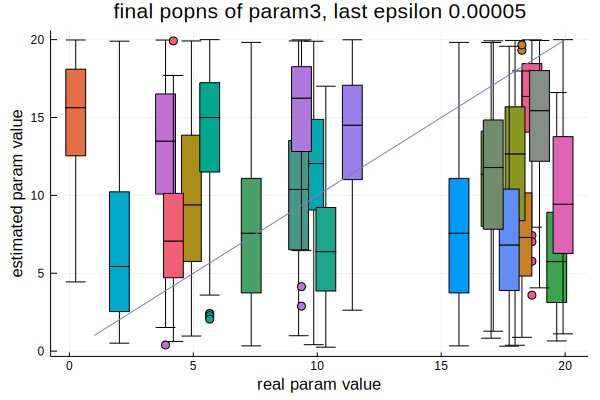

In [41]:
boxplot(real_param_vect3', final_popns3',title = "final popns of param3, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", label = "")
plot!(1:20, label = "")

In [32]:
# param1_run1=final_popns1[1,:]
# param1_run2=final_popns1[2,:]
# param1_run3=final_popns1[3,:]
# param1_run4=final_popns1[4,:]
# param1_run5=final_popns1[5,:]
# param1_run6=final_popns1[6,:]
# param1_run7=final_popns1[7,:]
# param1_run8=final_popns1[8,:]
# param1_run9=final_popns1[9,:];


# vals = []
# for i in range(1,stop = 10)
#     push!(vals,repeat([real_param_vect1[i]],outer = 300))
# end
# vals = collect(Iterators.flatten(vals))

# # flatfinpops = collect(Iterators.flatten(final_popns1))
# flatfinpops = collect(Iterators.flatten(Array([param1_run1,param1_run2,param1_run3,param1_run4,param1_run5,param1_run6,param1_run7,param1_run8,param1_run9,final_popns1[10,:]])))

# boxplot(vals,flatfinpops, label="", title = "final popns of param1, last epsilon 0.00005", xlab = "real param value", ylab = "estimated param value", size = (700,500))
# plot!([1:20], label = "")